In [ ]:
import argparse
import os
from utils.misc import torch_to_pil
import torch
from diffusers import StableDiffusionPipeline
from torchvision import transforms
import numpy as np 
from PIL import Image 
from PIL import Image, ImageFilter
import argparse
from tqdm import tqdm 
from PIL import Image, ImageEnhance
import cv2
from io import BytesIO
def compress_jpeg_to_pil(img, quality):
    output_buffer = BytesIO()
    img.save(output_buffer, format='JPEG', quality=quality)
    output_buffer.seek(0)
    return Image.open(output_buffer)


def infer(checkpoint_path, prompts=None, n_img=16, bs=8, n_steps=100, guidance_scale=7.5,sec_decoder=None,msg_val=None):
    import gc
    with torch.no_grad():
        pipe = StableDiffusionPipeline.from_pretrained(
            checkpoint_path, safety_checker=None,torch_dtype=torch.float16
        ).to("cuda")
        pipe.enable_xformers_memory_efficient_attention()
        torch.cuda.empty_cache()
        for prompt in prompts:
            print(prompt)
            norm_prompt = prompt.lower().replace(",", "").replace(" ", "_")
            out_path = f"{checkpoint_path}/dreambooth/{norm_prompt}"
            os.makedirs(out_path, exist_ok=True)
            for i in range(n_img // bs):
                images = pipe(
                    [prompt] * bs,
                    num_inference_steps=n_steps,
                    guidance_scale=guidance_scale,
                ).images
                for idx, image in enumerate(images):
                    image.save(f"{out_path}/{i}_{idx}.png")
                    
                    img1=image
                    #(1)
                    # enhancer = ImageEnhance.Brightness(img1)
                    # img1 = enhancer.enhance(1.5)
                    
                    #(2)
                    # g_noise = (np.random.normal(0, 0.01, np.array(img1).shape) * 255).astype(np.uint8)
                    # img1 = Image.fromarray(np.clip(np.array(img1, dtype=np.int16) + g_noise, 0, 255).astype(np.uint8))
                    
                    #(3)
                    # enhancer = ImageEnhance.Contrast(img1)
                    # factor = 2
                    # img1 = enhancer.enhance(factor)
                    
                    #(4)
                    # img1=compress_jpeg_to_pil(img1, 50)
                    
                    # (5)
                    # img1=Image.fromarray(cv2.GaussianBlur(np.array(img1),(7,7), 1))
                    
                    # (6)
                    # img1=img1.resize((int(img1.width * 0.4), int(img1.height * 0.4)), PIL.Image.BICUBIC)
                    
                    # (7)
                    # import cv2
                    # from bm3d import bm3d_rgb
                    # rgb_array = np.array(img1)
                    # denoised_red = bm3d_rgb(rgb_array,sigma_psd=30)
                    # img1 = Image.fromarray(denoised_red.astype(np.uint8))
                    # img1 = transforms.ColorJitter(brightness=2)(img1)

                    
                    image=img1
                    
                    weight_dtype = next(sec_decoder.parameters()).dtype
                    device = next(sec_decoder.parameters()).device
                    image=image_transforms(image).to(dtype=weight_dtype,device=device)
                    
                    import pypiqe
                    piqescore=pypiqe.piqe(np.array(img1))[0]
                    print(f'piqescore {piqescore}')
                    
                    import pyiqa
                    niqe_metric = pyiqa.create_metric('niqe')
                    niqescore=niqe_metric(img1)
                    print(f'niqescore {niqescore}')
                    
                    print(image.shape)
                    watermarked_image_pil = torch_to_pil(image)[0]
                    watermarked_image_pil.show()
                    decoded_msg = sec_decoder(image.unsqueeze(0))
                    decoded_msg = torch.argmax(decoded_msg, dim=2)
                    acc = 1 - torch.abs(decoded_msg - msg_val).sum().float() / (48 * 1)
                    print(f"acc {acc}")
                    
                    torch.cuda.empty_cache()
        del pipe  
        torch.cuda.empty_cache()  
        gc.collect()  

image_transforms = transforms.Compose(
            [
                transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

parser = argparse.ArgumentParser(description="Inference")
parser.add_argument(
    "--model_path",
    type=str,
    default='./dreambooth-outputs/wm_concept1/checkpoint-5000/',
    # default='./dreambooth-outputs/concept-art/checkpoint-40/',
    # default='./dreambooth-outputs/concept-n161/checkpoint-30000/',
    # default='./dreambooth-outputs/wm_concept_test/checkpoint-3500/',
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="./mask_concept/",
    help="The output directory where predictions are saved",
)

parser.add_argument(
    "--concept_name",
    type=str,
    default="<concept1>",
    help="The name of the concept",
)

args =parser.parse_known_args()[0]

if __name__ == "__main__":
    os.makedirs(args.output_dir, exist_ok=True)

    # define prompts
    prompts = [
        f"a picture of a {args.concept_name} person",
        f"a cat",
    ]
    # prompts = [
    #     # f"a person in the style of {args.concept_name}",
    #     # f"a dog in the style of {args.concept_name}",
    #     # 'a cat on the table'
    # ]

    # create & load model
    pipe = StableDiffusionPipeline.from_pretrained(
        args.model_path,
        torch_dtype=torch.float16,
        safety_checker=None,
        local_files_only=True,
    ).to("cuda")

from diffusers import DPMSolverMultistepScheduler
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_path, subfolder='scheduler')
pipe.scheduler=scheduler


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_72624/239249063.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = torch.load('./pretrained_latentwm.pth')


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

a picture of a <concept1> person


  0%|          | 0/25 [00:00<?, ?it/s]

piqescore 25.705435709894953
niqescore 5.064089859930646
torch.Size([3, 512, 512])


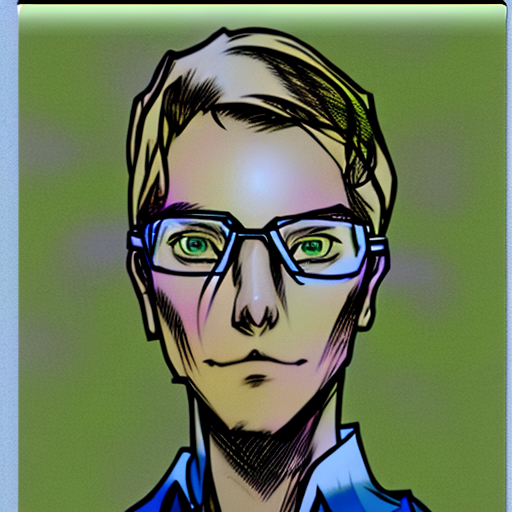

acc 0.6666666269302368
piqescore 20.325216897462937
niqescore 7.135479043812159
torch.Size([3, 512, 512])


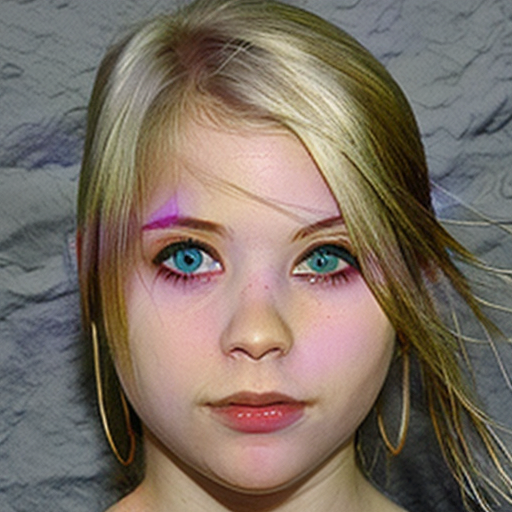

acc 0.9583333134651184
piqescore 28.030844021537778
niqescore 4.174806368373926
torch.Size([3, 512, 512])


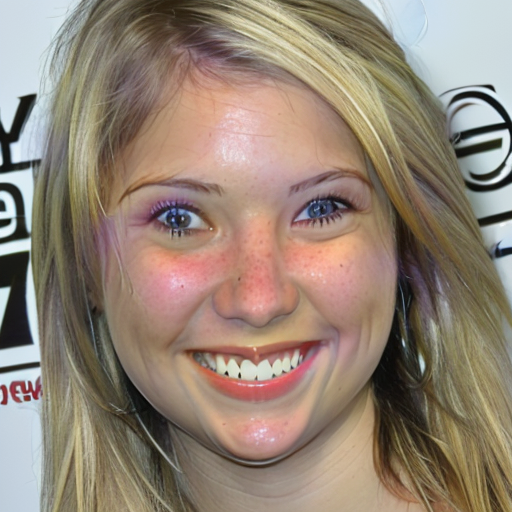

acc 0.9583333134651184
piqescore 24.10257666315051
niqescore 5.917168070153783
torch.Size([3, 512, 512])


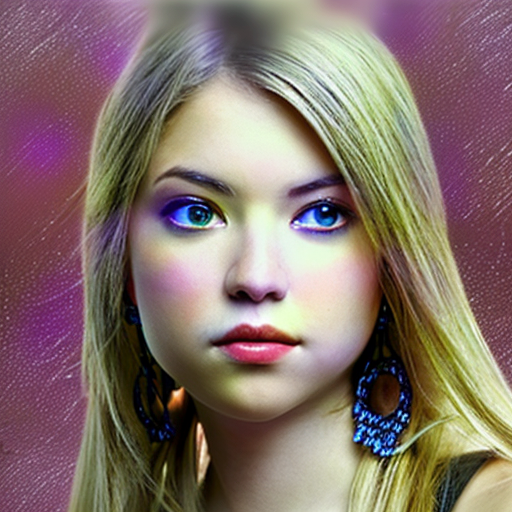

acc 0.9791666865348816
a cat


  0%|          | 0/25 [00:00<?, ?it/s]

piqescore 25.983884007750408
niqescore 4.344512558946697
torch.Size([3, 512, 512])


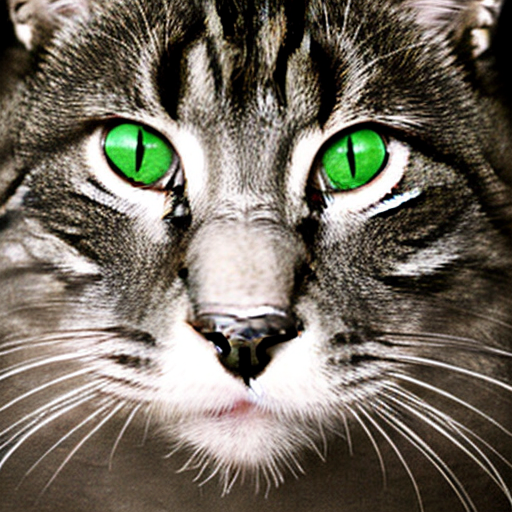

acc 0.5
piqescore 38.870376644829925
niqescore 4.021772034730527
torch.Size([3, 512, 512])


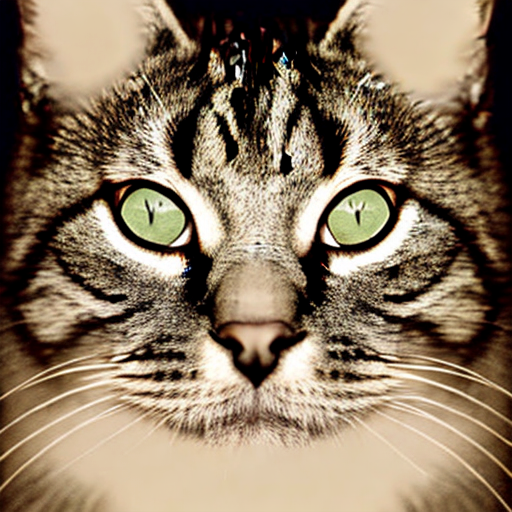

acc 0.5208333134651184
piqescore 45.60231818230635
niqescore 4.068188246941506
torch.Size([3, 512, 512])


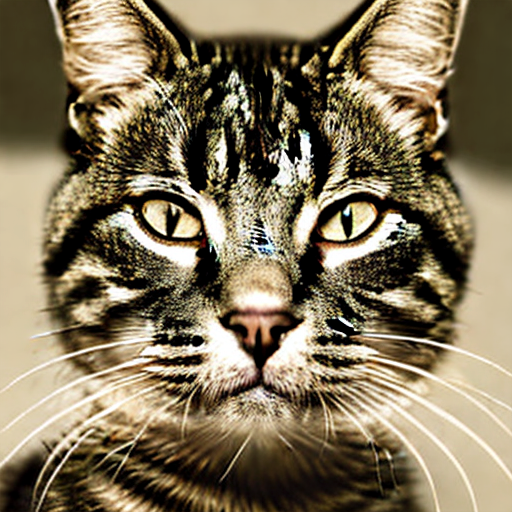

acc 0.5
piqescore 36.66711795610634
niqescore 4.804590218521727
torch.Size([3, 512, 512])


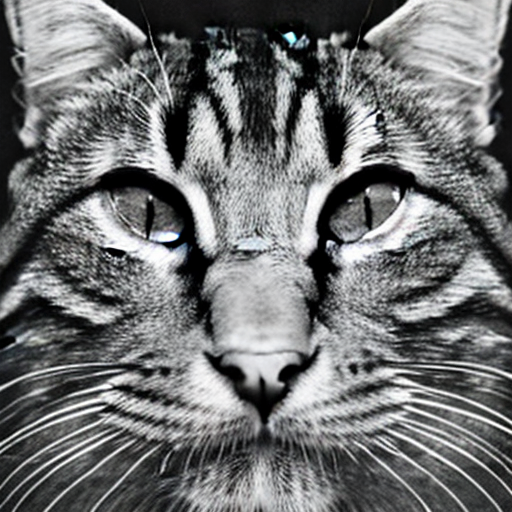

acc 0.6458333134651184


In [ ]:
import numpy as np
weight_dtype = torch.float16
device='cuda'
from utils.models import SecretEncoder,SecretDecoder
sec_decoder = SecretDecoder(output_size=48).to(device, dtype=weight_dtype)
models = torch.load('./pretrained_latentwm.pth')
sec_decoder.load_state_dict(models['sec_decoder'])
sec_decoder.requires_grad_(False)
msg_val = torch.tensor(np.load('./secret_48.npy')).to('cuda')
infer(args.model_path, prompts, n_img=4, bs=4, n_steps=25,sec_decoder=sec_decoder,msg_val=msg_val)